In [123]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.mining import *
from intercluster.pruning import *
from intercluster.experiments import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [426]:
palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

cluster_color_dict = {i: cmap(7 - i) for i in range(8)}
cluster_color_dict[-1] = 'grey'

color_dict = {'pond' : cmap(5), 'lake': cmap(1), 'wetland': cmap(7), 'other' : cmap(6)}

# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (doing so, however, will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

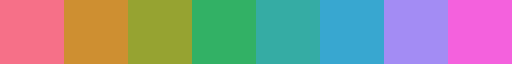

In [38]:
cmap

### Load data

In [565]:
pond_df = pd.read_csv('../data/pond_lake/pond_data.csv', encoding_errors='ignore')
select_features = ['mean_surfacearea_m2', 'max_depth_m', 'macrophytes_percentcover','tn_ugpl', 'tp_ugpl', 'chla_ugpl', 'ph']
sub_pond_df = pond_df.loc[:, select_features]
sub_pond_df.columns = ['surface_area', 'depth', 'veg_cover', 'TN', 'TP', 'CHL', 'pH',]
sub_pond_df['ecosystem'] = 'pond'

# Convert m2 to ha
sub_pond_df['surface_area'] = sub_pond_df['surface_area'] / 10000

# convert veg cover from percentage to proportion
sub_pond_df['veg_cover'] = sub_pond_df['veg_cover'] / 100

'''
simplified_terms = []
for term in pond_df['author_term']:
    if 'pond' in term:
        simplified_terms.append('pond')
    elif 'lake' in term:
        simplified_terms.append('lake')
    elif 'wetland' in term:
        simplified_terms.append('wetland')
    else:    
        simplified_terms.append('other')
sub_pond_df['ecosystem'] = simplified_terms
'''

# remove rows with more than 2 missing features
sub_pond_df = sub_pond_df.dropna(thresh=sub_pond_df.shape[1]-1)

sub_pond_df



,surface_area,depth,veg_cover,TN,TP,CHL,pH,ecosystem
461,13.0000,NaN,0.10,500.0,65.0,20.0,7.50,pond
462,0.1000,NaN,0.20,19380.0,1300.0,30.8,7.04,pond
463,0.6000,NaN,0.65,17300.0,1410.0,26.3,7.20,pond
464,0.5500,NaN,0.35,18650.0,1140.0,28.0,7.27,pond
465,0.6000,NaN,0.60,11120.0,950.0,46.0,7.41,pond
...,...,...,...,...,...,...,...,...
1269,0.0577,1.69,0.22,1006.0,20.0,4.0,8.00,pond
1270,0.2206,1.77,0.04,805.0,45.0,7.0,8.10,pond
1271,0.0682,2.32,0.92,1903.0,149.0,68.0,7.90,pond
1325,0.3360,4.50,NaN,1700.0,27.0,32.3,6.50,pond


In [533]:
sub_pond_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 4 to 1326
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   surface_area  449 non-null    float64
 1   depth         382 non-null    float64
 2   veg_cover     197 non-null    float64
 3   ecosystem     450 non-null    object 
dtypes: float64(3), object(1)
memory usage: 17.6+ KB


In [534]:
sub_pond_df.ecosystem.value_counts()

ecosystem
pond    450
Name: count, dtype: int64

<Axes: >

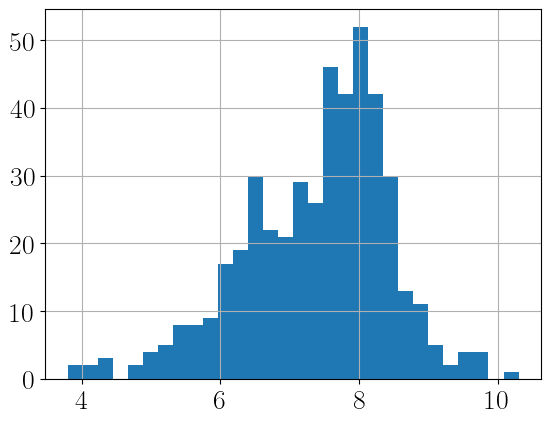

In [208]:
sub_pond_df.ph.hist(bins=30)

In [582]:
lake_df = pd.read_csv('../data/pond_lake/nla12_keyvariables_data.csv')
lake_chemical = pd.read_csv('../data/pond_lake/nla2012_waterchem_wide.csv')
phs = []
for idt in lake_df.UID:
    res = lake_chemical.loc[lake_chemical.UID == idt, 'PH_RESULT'].values
    if len(res) == 1:
        phs.append(res[0])
    else:
        phs.append(np.nan)
lake_df['pH'] = phs

select_features = ['AREA_HA', 'INDEX_SITE_DEPTH', 'AMITOTAL', 'NTL_RESULT', 'PTL_RESULT', 'CHLX_RESULT', 'pH']
sub_lake_df = lake_df.loc[:, select_features]
sub_lake_df.columns = ['surface_area', 'depth', 'veg_cover', 'TN', 'TP', 'CHL', 'pH']
sub_lake_df['ecosystem'] = 'lake'

# Convert from mg/L to ug/L
sub_lake_df['TN'] = sub_lake_df['TN'] * 1000

# remove rows with more than 2 missing features
sub_pond_df = sub_pond_df.dropna(thresh=sub_pond_df.shape[1]-1)

sub_lake_df

,surface_area,depth,veg_cover,TN,TP,CHL,pH,ecosystem
0,1301.871970,13.1,NaN,505.0,30.0,18.000000,8.54,lake
1,1301.871970,13.7,0.155000,376.0,25.0,17.520000,8.28,lake
2,72.950420,17.3,0.225000,389.0,12.0,10.000000,7.37,lake
3,10363.258480,6.5,NaN,449.0,56.0,32.000000,8.34,lake
4,4731.474336,19.8,0.030000,344.0,37.0,8.945455,7.99,lake
...,...,...,...,...,...,...,...,...
1133,32.047821,15.8,NaN,59.0,14.0,1.032000,7.01,lake
1134,1.758773,2.5,0.367500,480.0,64.0,3.272000,8.77,lake
1135,14.420022,5.5,0.241667,318.0,33.0,0.829333,8.27,lake
1136,2762.171646,18.5,0.120000,355.0,36.0,5.493333,8.81,lake


In [583]:
wetland_df = pd.read_csv('../data/pond_lake/nwca2011_aachar.csv')
wetland_vegetation = pd.read_csv('../data/pond_lake/nwca2011_vegmetrics.csv')
wetland_chemical = pd.read_csv('../data/pond_lake/nwca2011_waterchem.csv')
wetland_chl = pd.read_csv('../data/pond_lake/nwca2011_chla.csv')

depths = []
veg_covers = []
tns = []
tps = []
chls = []
phs = []
for uid in wetland_df.UID:
    res = wetland_vegetation.loc[wetland_vegetation.UID == uid, 'MAX_H2O_DEPTH'].values
    if len(res) == 1:
        depths.append(res[0])
    else:
        depths.append(np.nan)
    
    res1 = wetland_vegetation.loc[wetland_vegetation.UID == uid, 'XCOV_H2O_EMERGVEG'].values
    res2 = wetland_vegetation.loc[wetland_vegetation.UID == uid, 'XCOV_H2O_AQVEG'].values
    if len(res1) == 1 and len(res2) == 1:
        veg_covers.append(res1[0] + res2[0])
    else:
        veg_covers.append(np.nan)
    
    res = wetland_chemical.loc[wetland_chemical.UID == uid, 'TN'].values
    if len(res) == 1:
        tns.append(res[0])
    else:
        tns.append(np.nan)
    
    res = wetland_chemical.loc[wetland_chemical.UID == uid, 'TP'].values
    if len(res) == 1:
        tps.append(res[0])
    else:
        tps.append(np.nan)
    
    res = wetland_chl.loc[wetland_chl.UID == uid, 'CHLA'].values
    if len(res) == 1:
        chls.append(res[0])
    else:
        chls.append(np.nan)
    
    res = wetland_chemical.loc[wetland_chemical.UID == uid, 'PH'].values
    if len(res) == 1:
        phs.append(res[0])
    else:
        phs.append(np.nan)

wetland_df['depth'] = depths
wetland_df['veg_cover'] = veg_covers
wetland_df['TN'] = tns
wetland_df['TP'] = tps
wetland_df['CHL'] = chls
wetland_df['pH'] = phs

select_features = ['AA_AREA', 'depth', 'veg_cover', 'TN', 'TP', 'CHL', 'pH']
sub_wetland_df = wetland_df.loc[:, select_features]
sub_wetland_df.columns = ['surface_area', 'depth', 'veg_cover', 'TN', 'TP', 'CHL', 'pH']
sub_wetland_df['ecosystem'] = 'wetland'

# Convert from cm to m
# NOTE: I'm just guessing this was originally in cm, since depths are very large otherwise
sub_wetland_df['depth'] = sub_wetland_df['depth'] / 100

# Convert from percent to proportion
sub_wetland_df['veg_cover'] = sub_wetland_df['veg_cover'] / 100

# Convert from mg/L to ug/L
sub_wetland_df['TN'] = sub_wetland_df['TN'] * 1000

sub_wetland_df = sub_wetland_df.dropna(thresh=sub_wetland_df.shape[1]-1)

<Axes: >

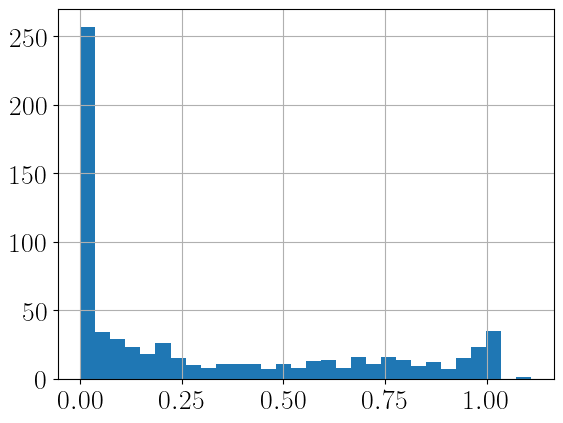

In [584]:
sub_wetland_df.veg_cover.hist(bins=30)

In [585]:
df = pd.concat([sub_pond_df, sub_lake_df, sub_wetland_df], ignore_index=True)
df.surface_area = np.log(df.surface_area + 1)
df.depth = np.log(df.depth + 1)
df.TN = np.log(df.TN + 1)
df.TP = np.log(df.TP + 1)
df.CHL = np.log(df.CHL + 1)

# Standard scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.iloc[:, :-1])
scaled_df = pd.DataFrame(scaled_features, columns=df.columns[:-1])
scaled_df['ecosystem'] = df['ecosystem'].values

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
imputed_features = imputer.fit_transform(scaled_df.iloc[:, :-1])
imputed_df = pd.DataFrame(imputed_features, columns=scaled_df.columns[:-1])
imputed_df['ecosystem'] = scaled_df['ecosystem'].values

df = imputed_df

In [586]:
df

,surface_area,depth,veg_cover,TN,TP,CHL,pH,ecosystem
0,0.044817,0.180309,-0.704357,-0.449037,-0.079733,0.488301,-0.310321,pond
1,-1.077212,-1.009650,-0.423447,2.988871,2.093201,0.798521,-0.796422,pond
2,-0.911937,-0.815072,0.840648,2.882098,2.152360,0.684450,-0.627344,pond
3,-0.925941,-0.607806,-0.002082,2.952762,1.997553,0.729613,-0.553372,pond
4,-0.911937,-0.815072,0.700193,2.466468,1.864792,1.090603,-0.405427,pond
...,...,...,...,...,...,...,...,...
1897,-0.940405,-1.296281,-0.985267,-0.723990,-0.375264,-1.327922,0.376563,wetland
1898,-0.940405,-1.214598,-0.985267,-0.873588,-0.482119,-0.789773,-0.806990,wetland
1899,-0.940405,-0.865938,-0.985267,-0.273195,-0.212621,-0.699098,-2.518914,wetland
1900,-0.960090,-0.865938,-0.962794,0.916073,1.314527,1.232062,-1.124013,wetland


<Axes: >

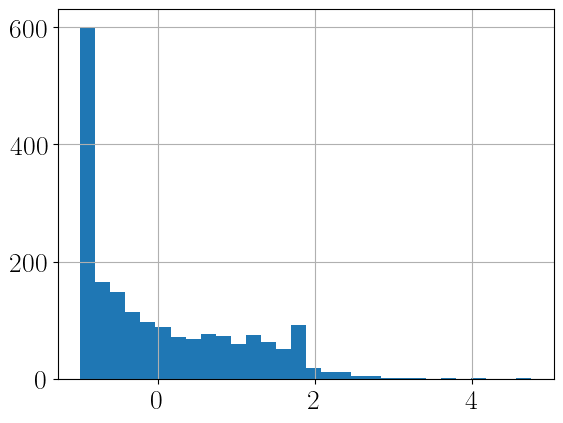

In [587]:
df.veg_cover.hist(bins=30)

In [589]:
sub_pond_df

,surface_area,depth,veg_cover,TN,TP,CHL,pH,ecosystem
461,13.0000,NaN,0.10,500.0,65.0,20.0,7.50,pond
462,0.1000,NaN,0.20,19380.0,1300.0,30.8,7.04,pond
463,0.6000,NaN,0.65,17300.0,1410.0,26.3,7.20,pond
464,0.5500,NaN,0.35,18650.0,1140.0,28.0,7.27,pond
465,0.6000,NaN,0.60,11120.0,950.0,46.0,7.41,pond
...,...,...,...,...,...,...,...,...
1269,0.0577,1.69,0.22,1006.0,20.0,4.0,8.00,pond
1270,0.2206,1.77,0.04,805.0,45.0,7.0,8.10,pond
1271,0.0682,2.32,0.92,1903.0,149.0,68.0,7.90,pond
1325,0.3360,4.50,NaN,1700.0,27.0,32.3,6.50,pond


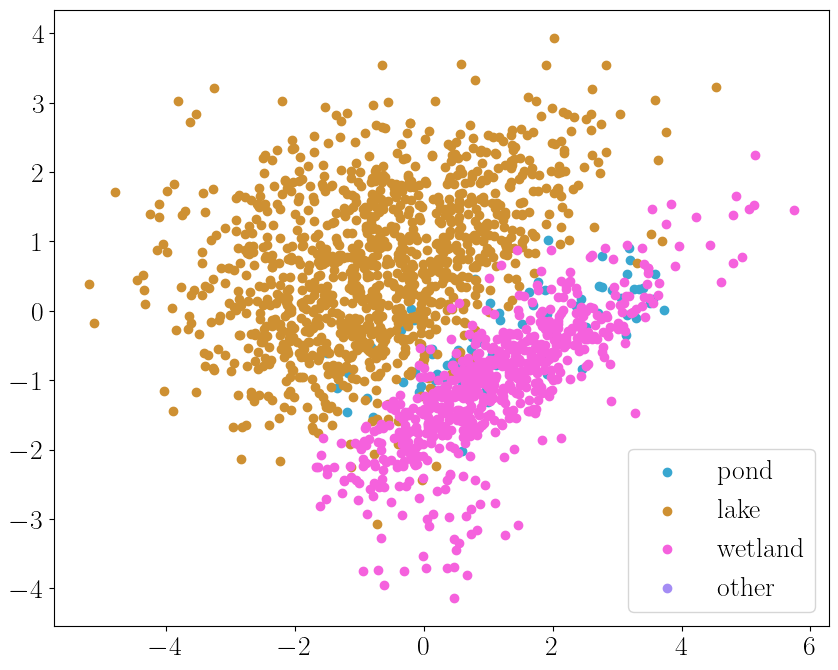

In [613]:
pca = PCA(n_components=2)
data_dim = pca.fit_transform(df.iloc[:, :-1])

fig, ax = plt.subplots(figsize=(10, 8))
for ecotype in ['pond', 'lake', 'wetland', 'other']:
    idx = df['ecosystem'] == ecotype
    ax.scatter(data_dim[idx,0], data_dim[idx,1], label=ecotype, color=color_dict[ecotype])

plt.legend()

<Axes: xlabel='surface_area', ylabel='depth'>

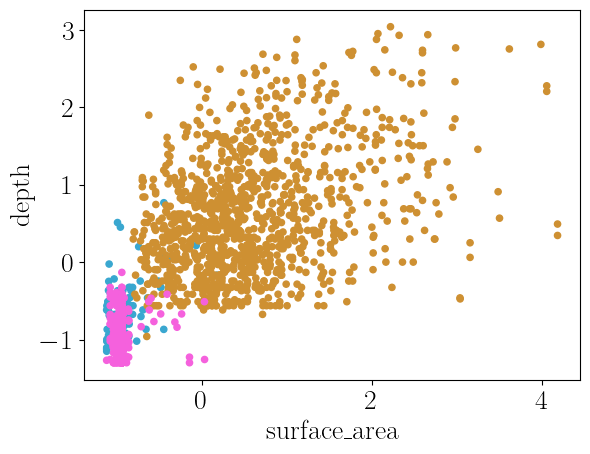

In [590]:
df.plot.scatter(x='surface_area', y='depth', c=df['ecosystem'].map(color_dict))

<Axes: xlabel='surface_area', ylabel='veg_cover'>

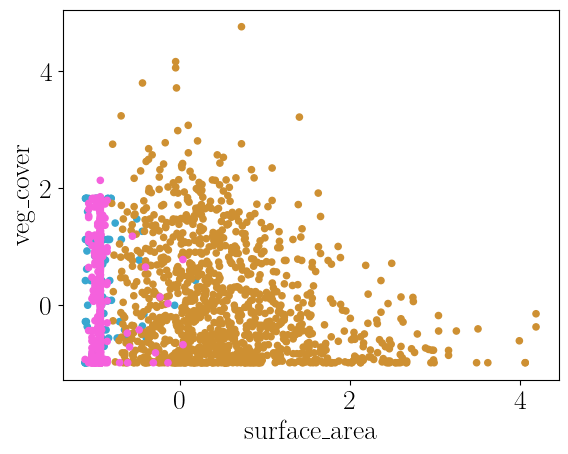

In [591]:
df.plot.scatter(x='surface_area', y='veg_cover', c=df['ecosystem'].map(color_dict))

### Classification

In [592]:
# Data and labels
X = df.iloc[:, :-1].values
label_dict = {'pond': 0, 'lake': 1, 'wetland': 2, 'other': 3}
rev_label_dict = {v: k for k, v in label_dict.items()}
y_true_ = np.array([label_dict[lab] for lab in df['ecosystem'].values])
y_true = labels_format(y_true_)

In [593]:
dt = DecisionTree(max_leaf_nodes = 3)
dt.fit(X, y_true)
y_pred = dt.predict(X)
y_pred_ = flatten_labels(y_pred)

In [594]:
N = y_true_.shape[0]
accuracy = (y_true_ == y_pred_).sum() / N
accuracy

0.9479495268138801

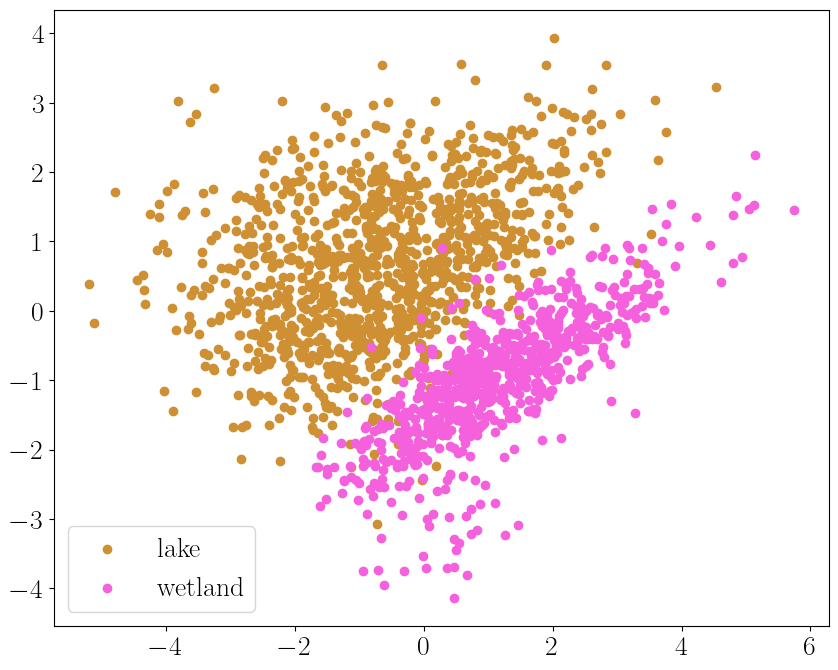

In [595]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_pred_):
    idx = y_pred_ == clabel
    ecotype = rev_label_dict[clabel]
    ax.scatter(data_dim[idx,0], data_dim[idx,1], label=ecotype, color=color_dict[ecotype])

plt.legend()

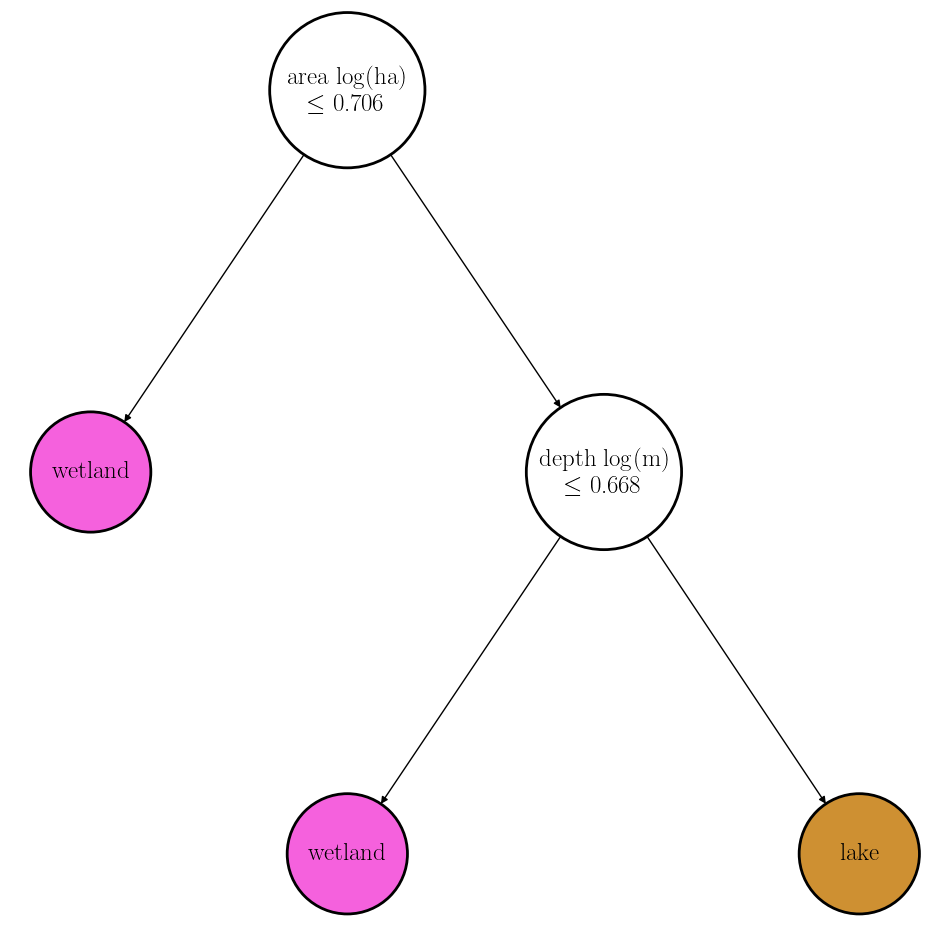

In [596]:
tree_color_dict = {i: color_dict[rev_label_dict[i]] for i in range(len(rev_label_dict))}
tree_labels = [rev_label_dict[i] for i in range(len(rev_label_dict))]
feature_labels = [r'area $\log$(ha)', r'depth $\log$(m)', 'veg_cover', r'TN $\log$(ug/L)',
                   r'TP $\log$(ug/L)', r'CHL $\log$(ug/L)', 'pH']
draw_tree(
    dt.root,
    feature_labels = feature_labels,
    leaf_labels = tree_labels,
    color_dict = tree_color_dict,
    data_scaler = scaler
)

Text(0, 0.5, 'depth (scaled)')

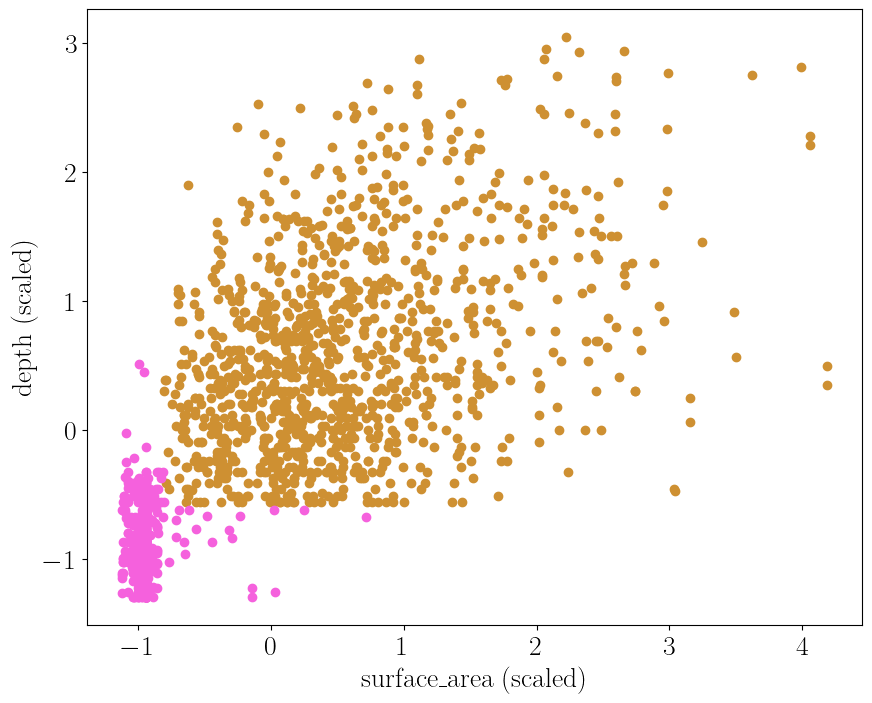

In [597]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_pred_):
    idx = y_pred_ == clabel
    ecotype = rev_label_dict[clabel]
    ax.scatter(X[idx,0], X[idx,1], label=ecotype, color=color_dict[ecotype])

ax.set_xlabel('surface_area (scaled)')
ax.set_ylabel('depth (scaled)')

### Clustering

In [598]:
# KMeans clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=seed)
kmeans.fit(X)
y_kmeans_ = kmeans.labels_
y_kmeans = labels_format(y_kmeans_)

/var/folders/gx/n_zylxjn46v7vssq3_z29kpr0000gn/T/ipykernel_49198/1880975785.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


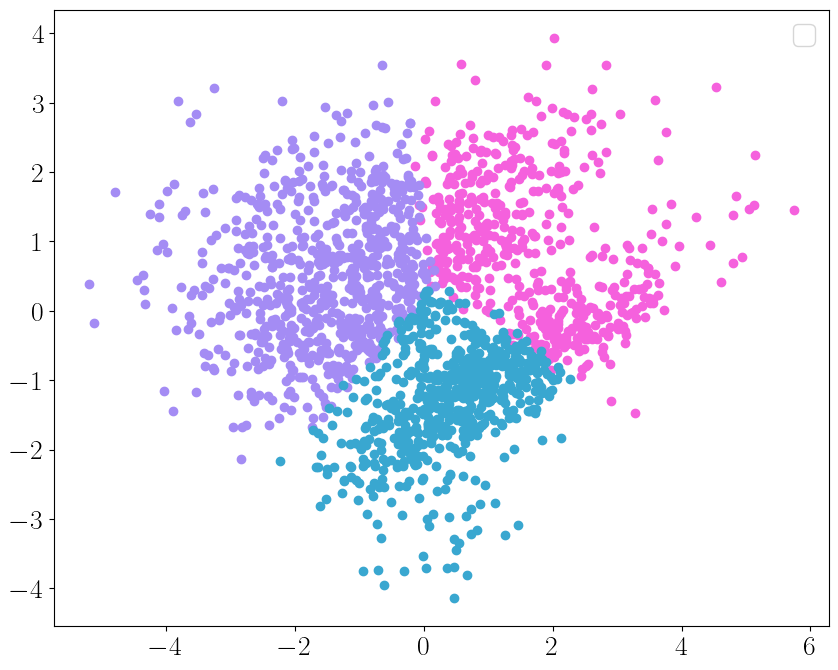

In [599]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_kmeans_):
    idx = y_kmeans_ == clabel
    ax.scatter(data_dim[idx,0], data_dim[idx,1], color=cluster_color_dict[clabel])

plt.legend()

In [614]:
# DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
y_dbscan_ = dbscan.fit_predict(X)
y_dbscan = labels_format(y_dbscan_)

KeyError: 8

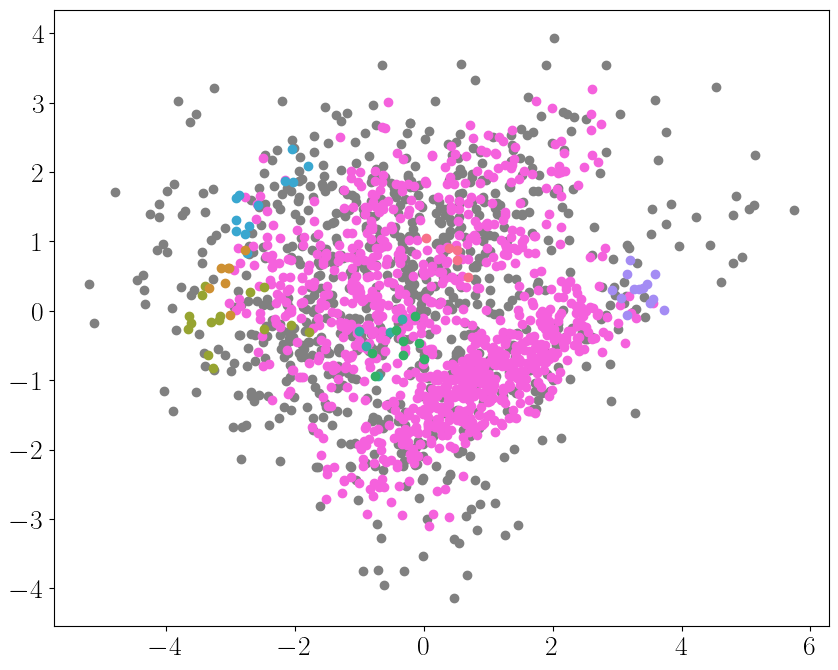

In [615]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_dbscan_):
    idx = y_dbscan_ == clabel
    ax.scatter(data_dim[idx,0], data_dim[idx,1], color=cluster_color_dict[clabel])

plt.legend()

In [616]:
# IMM
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)
exkmc_tree.fit(X)
y_exkmc = exkmc_tree.predict(X, leaf_labels = False)
y_exkmc_ = flatten_labels(y_exkmc)

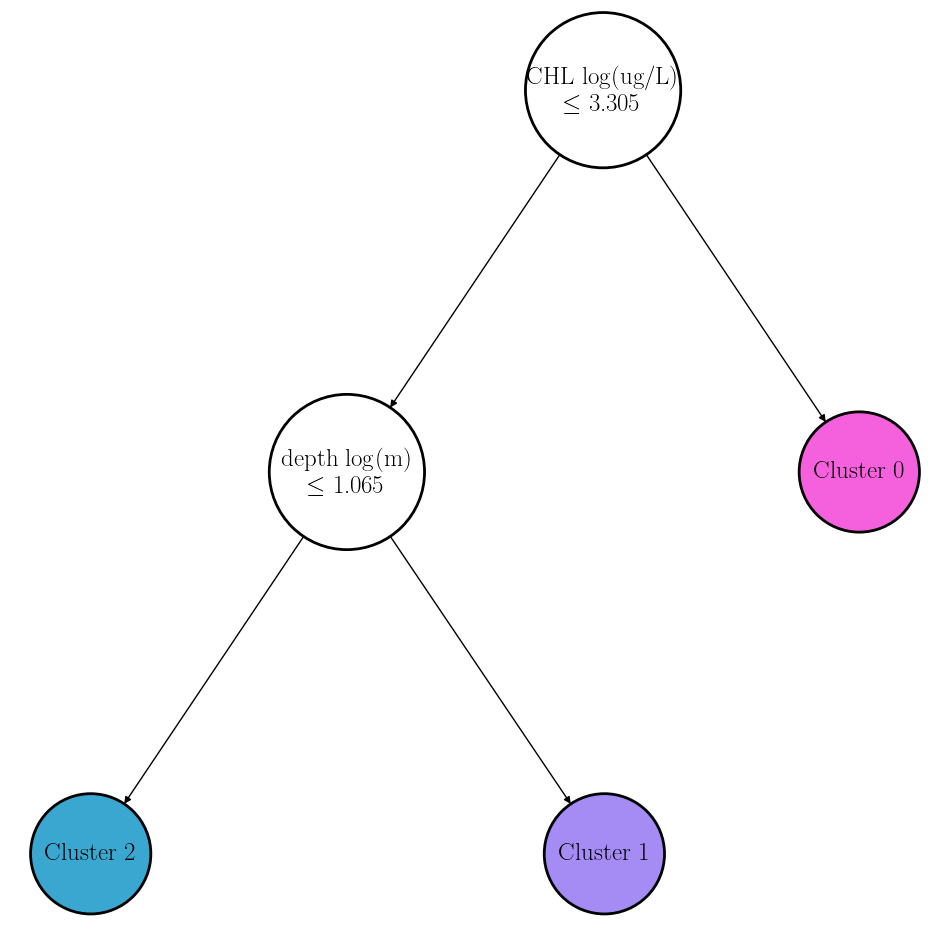

In [617]:
feature_labels = [r'area $\log$(ha)', r'depth $\log$(m)', 'veg_cover', r'TN $\log$(ug/L)',
                   r'TP $\log$(ug/L)', r'CHL $\log$(ug/L)', 'pH']
draw_tree(
    exkmc_tree.root,
    feature_labels = feature_labels,
    color_dict = cluster_color_dict,
    data_scaler = scaler
)

In [559]:
df.columns

Index(['surface_area', 'depth', 'veg_cover', 'ecosystem'], dtype='object')

Text(0, 0.5, 'CHL (scaled)')

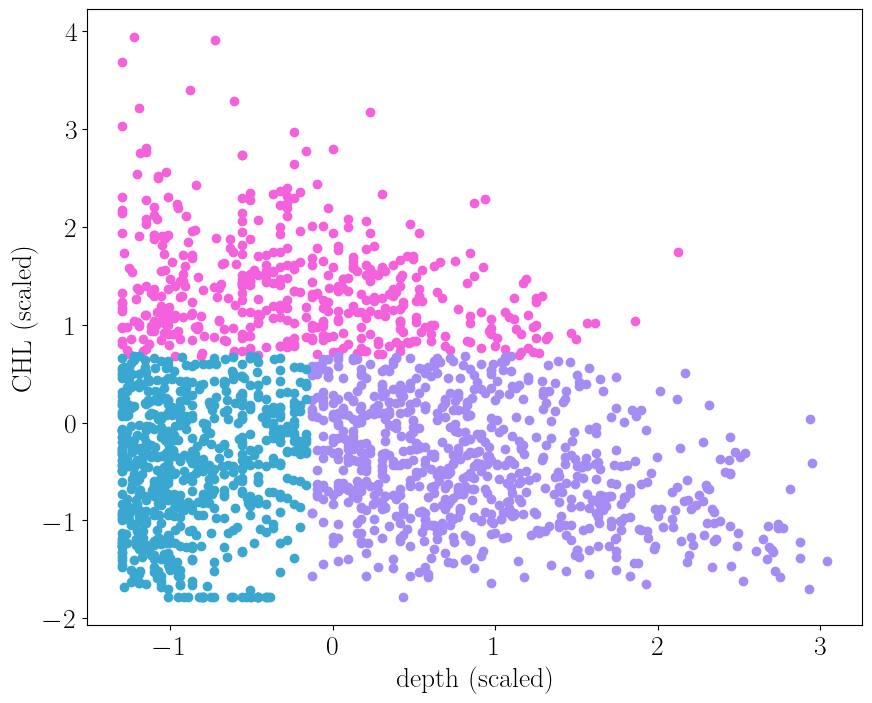

In [619]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_exkmc_):
    idx = y_exkmc_ == clabel
    ax.scatter(X[idx,1], X[idx,-2], color=cluster_color_dict[clabel])

ax.set_xlabel('depth (scaled)')
ax.set_ylabel('CHL (scaled)')

In [620]:
# Decision set clustering
lambd = 10.0
point_miner = PointwiseMiner(lambd = lambd, n_features = 2, rules_per_point = 10)
dsclust = DSCluster(lambd = 10, n_rules = k, rule_miner = point_miner)
dsclust.fit(X, y_kmeans)
y_dsclust = dsclust.predict(X)
y_dsclust_ = flatten_labels(y_dsclust) 

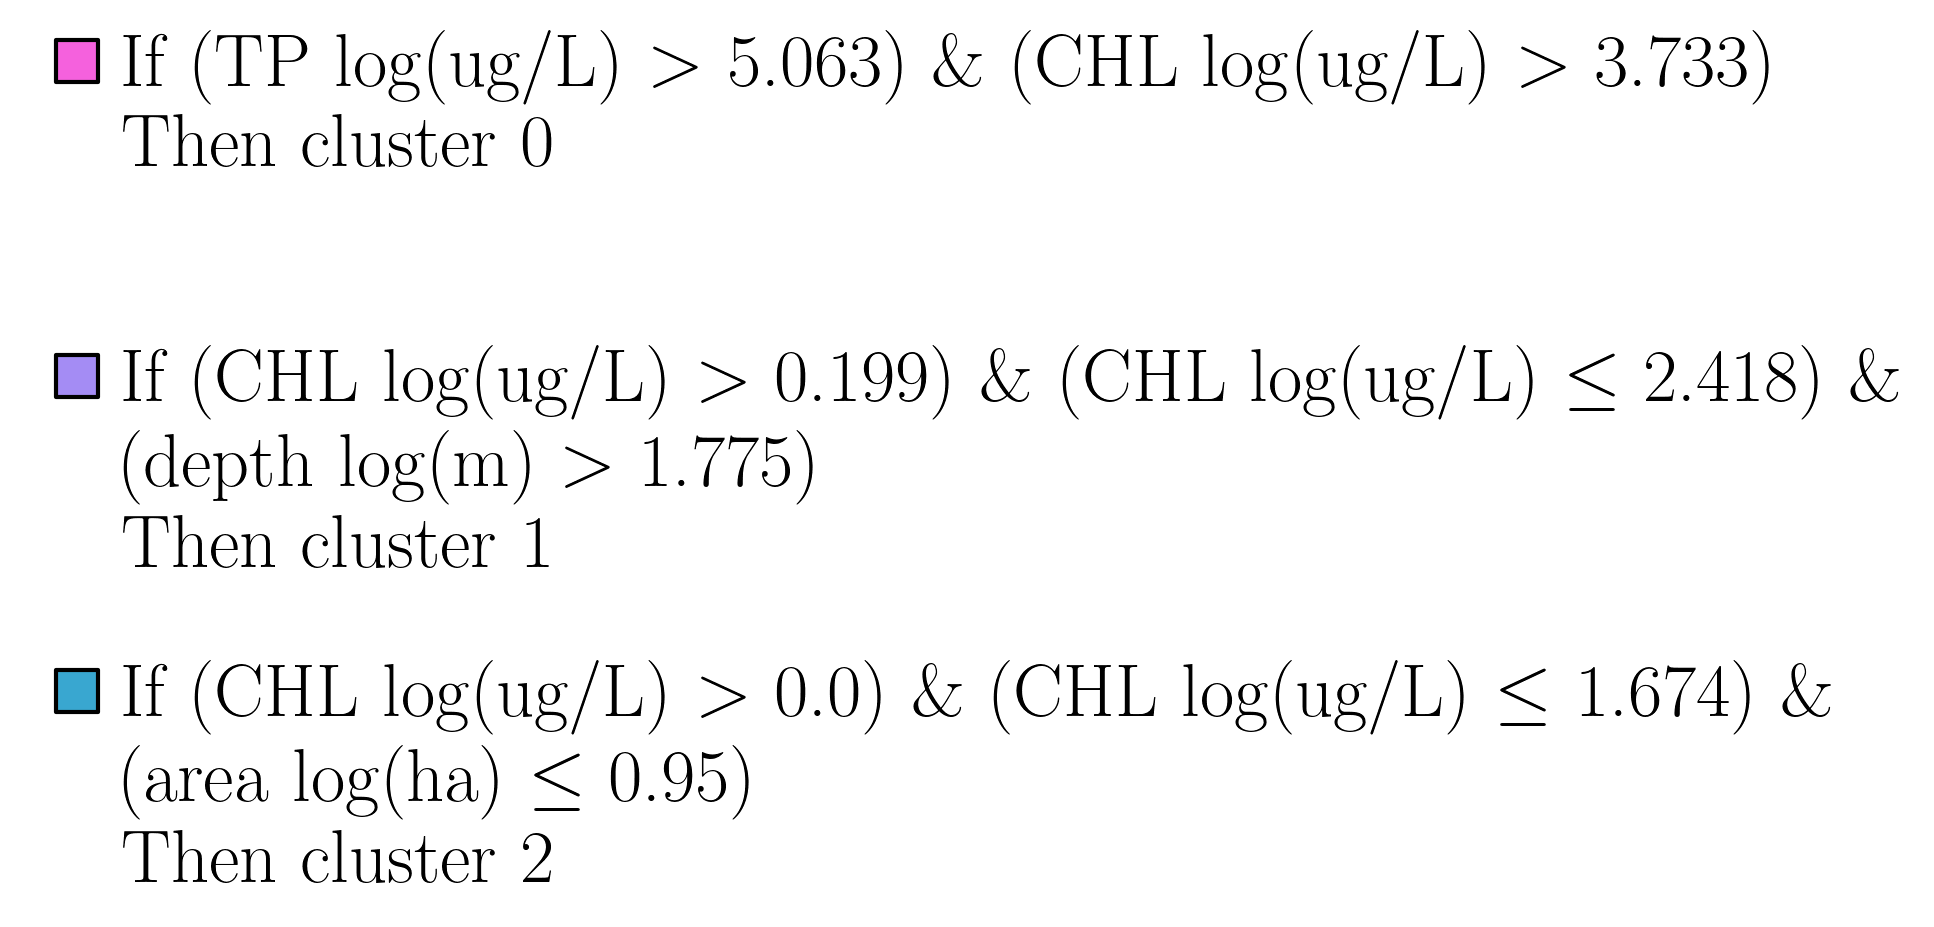

In [621]:
plot_decision_set(
    dsclust.decision_set,
    dsclust.decision_set_labels,
    feature_labels = feature_labels,
    data_scaler = scaler,
    color_dict = cluster_color_dict
)

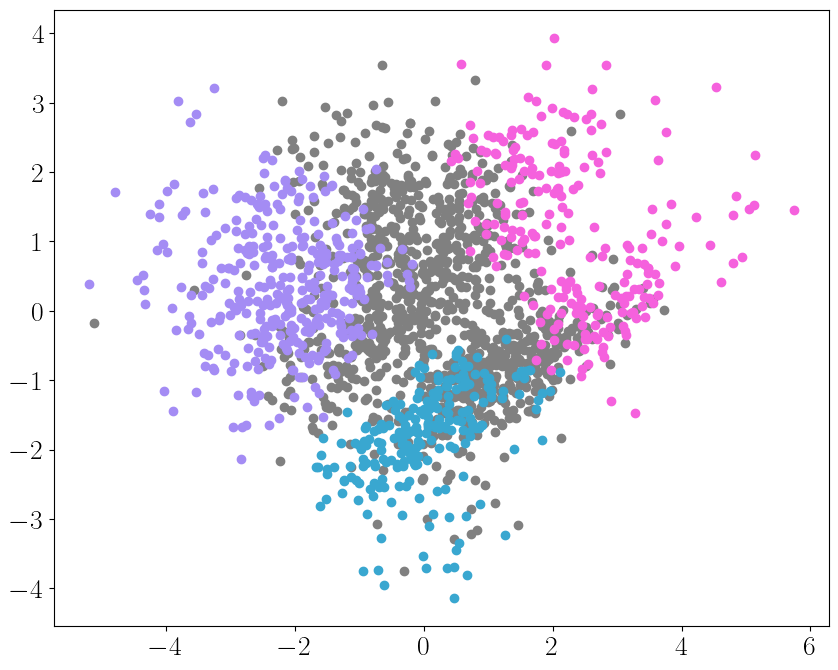

In [622]:
fig, ax = plt.subplots(figsize=(10, 8))
for clabel in np.unique(y_dsclust_):
    idx = y_dsclust_ == clabel
    ax.scatter(data_dim[idx,0], data_dim[idx,1], color=cluster_color_dict[clabel])

